In [1]:
import os
import zarr
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


class CFG:
    particles_name = [
        "apo-ferritin",
        "beta-amylase",
        "beta-galactosidase",
        "ribosome",
        "thyroglobulin",
        "virus-like-particle",
    ]

    resolution2ratio = {
        "A": 1 / 10,
        "0": 1,
        "1": 2,
        "2": 4,
    }

    particles2cls = {
        "none": 0,
        "apo-ferritin": 1,
        "beta-amylase": 2,
        "beta-galactosidase": 3,
        "ribosome": 4,
        "thyroglobulin": 5,
        "virus-like-particle": 6,
    }
    cls2particles = {
        0: "none",
        1: "apo-ferritin",
        2: "beta-amylase",
        3: "beta-galactosidase",
        4: "ribosome",
        5: "thyroglobulin",
        6: "virus-like-particle",
    }

    particle_radius = {
        "apo-ferritin": 60,
        "beta-amylase": 65,
        "beta-galactosidase": 90,
        "ribosome": 150,
        "thyroglobulin": 130,
        "virus-like-particle": 135,
    }

    particle_weights = {
        "apo-ferritin": 1,
        "beta-amylase": 0,
        "beta-galactosidase": 2,
        "ribosome": 1,
        "thyroglobulin": 2,
        "virus-like-particle": 1,
    }

    colormap = {
        # -1の場合は透明の色
    }


def read_zarr(zarr_pth, resolution="0"):
    zarr_store = zarr.open(zarr_pth, mode="r")

    tomogram = zarr_store[resolution][:]

    return tomogram


def read_info_json(
    base_dir="../inputs/train/overlay/ExperimentRuns/",
    exp_name="TS_5_4",
    particle_name="apo-ferritin",
):

    keys = set(
        [
            "apo-ferritin",
            "beta-amylase",
            "beta-galactosidase",
            "ribosome",
            "thyroglobulin",
            "virus-like-particle",
        ]
    )

    if particle_name not in keys:
        raise ValueError(
            f"Particle name should be one of the following: {keys}. Got {particle_name}."
        )

    read_json_path = os.path.join(base_dir, exp_name, "Picks", f"{particle_name}.json")

    with open(read_json_path, "r") as f:
        particle_info = json.load(f)

    coords = []
    for point in particle_info["points"]:
        coords.append(
            [point["location"]["z"], point["location"]["y"], point["location"]["x"]]
        )

    coords = np.array(coords)

    return coords


def scale_coordinates(coords, tomogram_shape):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()

    scaled_coords[:, 0] = coords[:, 0] / coords[:, 0].max() * tomogram_shape[0]
    scaled_coords[:, 1] = coords[:, 1] / coords[:, 1].max() * tomogram_shape[1]
    scaled_coords[:, 2] = coords[:, 2] / coords[:, 2].max() * tomogram_shape[2]

    return scaled_coords


def create_dataset(
    zarr_type="ctfdeconvolved",
    base_dir="../../inputs/train/",
    exp_name="TS_5_4",
    resolution="0",
    particle_names=[],
):
    zarr_name = f"{zarr_type}.zarr"
    zarr_pth = os.path.join(
        base_dir, "static/ExperimentRuns", exp_name, "VoxelSpacing10.000/", zarr_name
    )
    tomogram = read_zarr(zarr_pth, resolution=resolution)

    particle_info = {"corrds": {}, "scaled_corrds": {}}
    for particle_name in particle_names:
        coords = read_info_json(
            os.path.join(base_dir, "overlay/ExperimentRuns/"), exp_name, particle_name
        )
        scaled_coords = scale_coordinates(coords, tomogram.shape)
        particle_info["corrds"][particle_name] = coords
        particle_info["scaled_corrds"][particle_name] = scaled_coords

    return tomogram, particle_info


def normalise_by_percentile(data, min=5, max=99):
    min = np.percentile(data, min)
    max = np.percentile(data, max)
    data = (data - min) / (max - min)
    return data, min, max


class EziiDataset(Dataset):
    def __init__(
        self,
        exp_names,
        base_dir="../../inputs/train/static",
        particles_name=CFG.particles_name,
        resolution="0",
        zarr_type="ctfdeconvolved",
    ):
        self.exp_names = exp_names
        self.base_dir = base_dir
        self.particles_name = particles_name
        self.resolution = resolution
        self.zarr_type = zarr_type

    def __getitem__(self, i):
        exp_name = self.exp_names[i]  # TS_6_6

        tomogram, particle_info = create_dataset(
            particle_names=self.particles_name,
            resolution=self.resolution,
            exp_name=exp_name,
            zarr_type=self.zarr_type,
        )

        normalized_tomogram, min, max = normalise_by_percentile(tomogram)
        apo_ferritin = particle_info["scaled_corrds"]["apo-ferritin"]
        beta_amylase = particle_info["scaled_corrds"]["beta-amylase"]
        beta_galactosidase = particle_info["scaled_corrds"]["beta-galactosidase"]
        ribosome = particle_info["scaled_corrds"]["ribosome"]
        thyroglobulin = particle_info["scaled_corrds"]["thyroglobulin"]
        virus_like_particle = particle_info["scaled_corrds"]["virus-like-particle"]

        prticle_corrds = {
            "apo-ferritin": apo_ferritin,
            "beta-amylase": beta_amylase,
            "beta-galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus-like-particle": virus_like_particle,
        }

        segmentation_map = create_segmentation_map(
            tomogram, resolution=self.resolution, particle_coords=prticle_corrds
        )

        tomogram = padding(tomogram, self.resolution)
        normalized_tomogram = padding(normalized_tomogram, self.resolution)
        segmentation_map = padding(segmentation_map, self.resolution)

        return {
            "resolution": self.resolution,
            "exp_name": exp_name,
            "tomogram": tomogram,
            "normalized_tomogram": normalized_tomogram,
            "segmentation_map": segmentation_map,
            "apo_ferritin": apo_ferritin,
            "beta_amylase": beta_amylase,
            "beta_galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus_like_particle": virus_like_particle,
            "particle_corrds": prticle_corrds,
        }

    def __len__(self):
        return len(self.exp_names)


def padding(tomogram, resolution):
    if resolution == "0":  # 184, 630, 630 -> 184, 640, 640
        tomogram = np.pad(tomogram, ((0, 0), (5, 5), (5, 5)), mode="constant")
        return tomogram
    elif resolution == "1":  # 92, 315, 315 -> 92, 320, 320
        tomogram = np.pad(tomogram, ((0, 0), (2, 2), (2, 2)), mode="constant")
        return tomogram
    elif resolution == "2":  # 46, 158, 158 -> 46, 160, 160
        tomogram = np.pad(tomogram, ((0, 0), (1, 1), (1, 1)), mode="constant")
        return tomogram
    raise ValueError(
        f"Resolution should be one of the following: 0, 1, 2. Got {resolution}."
    )


def create_segmentation_map(tomogram, resolution, particle_coords={}):
    segmentation_map = np.zeros_like(tomogram)
    segmentation_map[:, :, :] = 0

    particle_radius = (
        CFG.particle_radius
    )  # {apo-ferritin: 60, beta-amylase: 65, beta-galactosidase: 90, ribosome: 150, thyroglobulin: 130, virus-like-particle: 135}
    particle2cls = CFG.particles2cls
    resolution_info = CFG.resolution2ratio  # {A: 1/10, 0: 1, 1: 2, 2: 4}

    r_by_particle = {}
    for particle_name, r in particle_radius.items():
        r_by_particle[particle_name] = (
            r * resolution_info["A"] / resolution_info[resolution]
        )

    for i, (paraticle_name, coords) in enumerate(particle_coords.items()):
        for z, y, x in coords:
            z, y, x = int(z), int(y), int(x)
            cls = particle2cls[paraticle_name]
            r = r_by_particle[paraticle_name]
            z_min = int(max(0, z - r))
            z_max = int(min(tomogram.shape[0], z + r))
            y_min = int(max(0, y - r))
            y_max = int(min(tomogram.shape[1], y + r))
            x_min = int(max(0, x - r))
            x_max = int(min(tomogram.shape[2], x + r))

            # x,y,zを中心に円計上にクラスを埋める
            # segmentation_map[z_min:z_max, y_min:y_max, x_min:x_max] = cls
            for z_ in range(z_min, z_max):
                for y_ in range(y_min, y_max):
                    for x_ in range(x_min, x_max):
                        if (z - z_) ** 2 + (y - y_) ** 2 + (x - x_) ** 2 < r**2:
                            segmentation_map[z_, y_, x_] = cls

    return segmentation_map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1410890

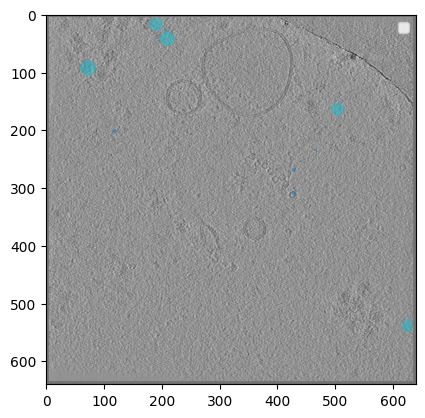

In [2]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 50
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)
plt.legend()

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

172448

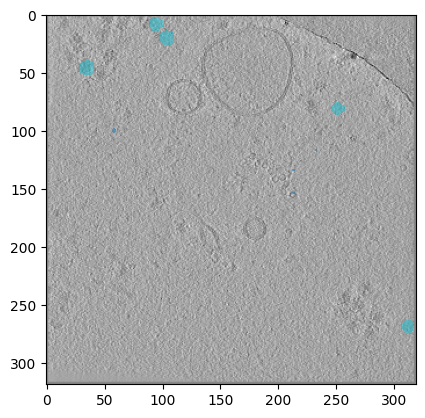

In [3]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="1",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 25
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

In [4]:
import torch
import torch.nn as nn
from icecream import ic


class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, middle_channels, kernel_size=3, padding="same"
        )
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(
            middle_channels, out_channels, kernel_size=3, padding="same"
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x


class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(1, 64, 64)
        self.TCB2 = TwoConvBlock(64, 128, 128)
        self.TCB3 = TwoConvBlock(128, 256, 256)
        self.TCB4 = TwoConvBlock(256, 512, 512)
        self.TCB5 = TwoConvBlock(512, 1024, 1024)
        self.TCB6 = TwoConvBlock(1024, 512, 512)
        self.TCB7 = TwoConvBlock(512, 256, 256)
        self.TCB8 = TwoConvBlock(256, 128, 128)
        self.TCB9 = TwoConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride=2)

        self.UC1 = UpConv(1024, 512)
        self.UC2 = UpConv(512, 256)
        self.UC3 = UpConv(256, 128)
        self.UC4 = UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, len(CFG.particles2cls), kernel_size=1)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim=1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.TCB9(x)

        x = self.conv1(x)

        return x

In [5]:
train_dataset = EziiDataset(
    exp_names=["TS_5_4", "TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)

valid_dataset = EziiDataset(
    exp_names=["TS_86_3", "TS_6_6"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

  0%|          | 0/5 [00:02<?, ?it/s]


184

In [6]:
import torch.nn.functional as F


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

  0%|          | 0/920 [00:00<?, ?it/s]/home/tatsuya/.pyenv/versions/3.9.16/envs/kaggle/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,
Valid-Epoch: 0, Loss: 0.16993515122600872: 100%|██████████| 368/368 [00:23<00:00, 15.34it/s]


Epoch: 0, Loss: 0.13934087753295898


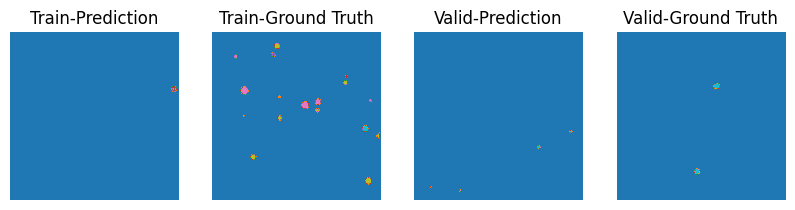

Valid-Epoch: 1, Loss: 0.12332300897485213: 100%|██████████| 368/368 [00:22<00:00, 16.36it/s]


Epoch: 1, Loss: 0.10105789452791214


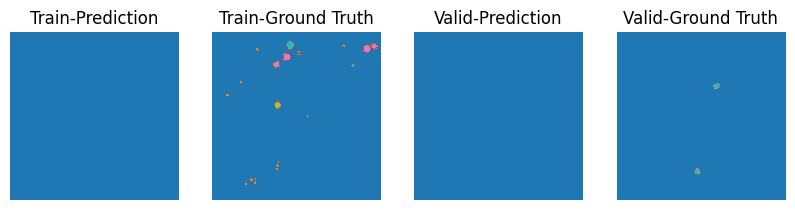

Valid-Epoch: 2, Loss: 0.29734831913779286: 100%|██████████| 368/368 [00:22<00:00, 16.46it/s]


Epoch: 2, Loss: 0.09955701977014542


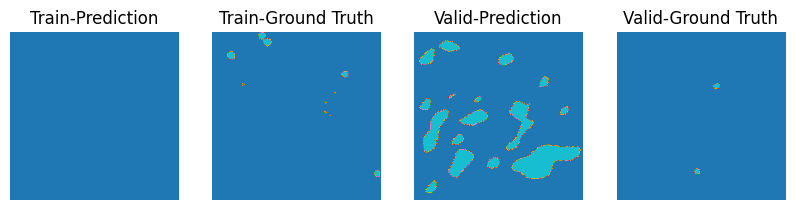

Valid-Epoch: 3, Loss: 0.10922083910048494: 100%|██████████| 368/368 [00:22<00:00, 16.44it/s]


Epoch: 3, Loss: 0.08433104306459427


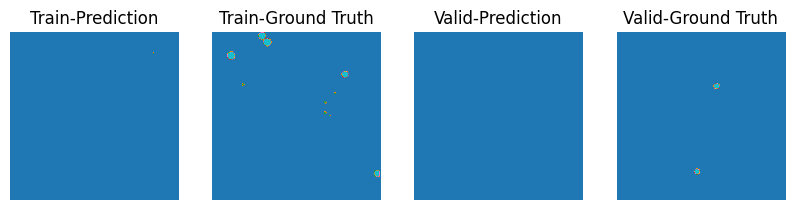

Valid-Epoch: 4, Loss: 0.1155338090358545: 100%|██████████| 368/368 [00:22<00:00, 16.61it/s] 


Epoch: 4, Loss: 0.08616667985916138


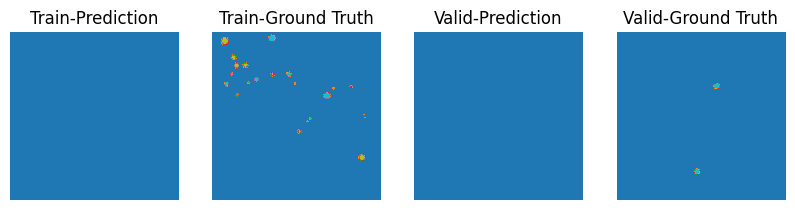

Valid-Epoch: 5, Loss: 0.10591924172046635: 100%|██████████| 368/368 [00:22<00:00, 16.71it/s] 


Epoch: 5, Loss: 0.06808513402938843


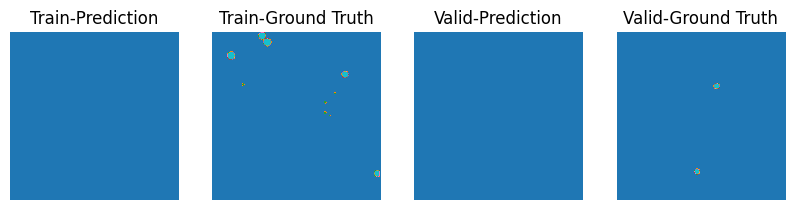

Valid-Epoch: 6, Loss: 0.10487442335073391: 100%|██████████| 368/368 [00:21<00:00, 16.87it/s]


Epoch: 6, Loss: 0.07719415426254272


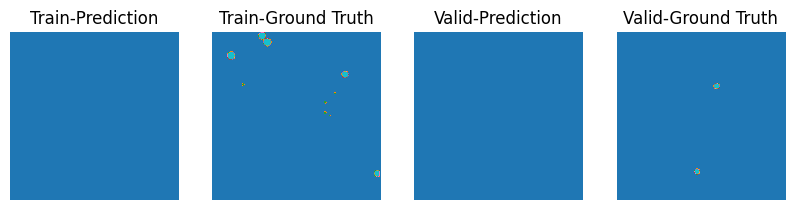

Valid-Epoch: 7, Loss: 0.10231020128475907: 100%|██████████| 368/368 [00:22<00:00, 16.69it/s]


Epoch: 7, Loss: 0.07379952073097229


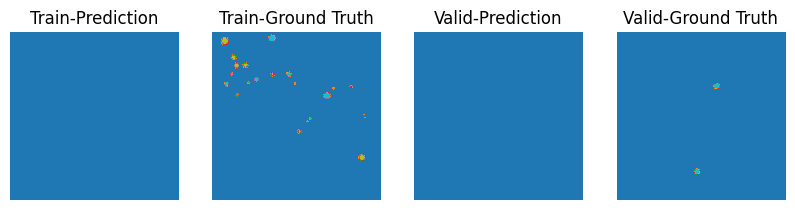

Valid-Epoch: 8, Loss: 0.11120343699281954: 100%|██████████| 368/368 [00:21<00:00, 16.84it/s]


Epoch: 8, Loss: 0.10339023917913437


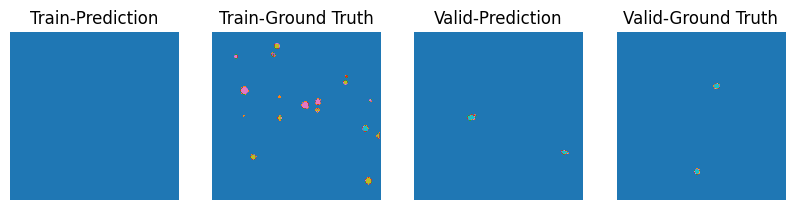

Valid-Epoch: 9, Loss: 0.11071652987890918: 100%|██████████| 368/368 [00:21<00:00, 16.91it/s]


Epoch: 9, Loss: 0.08952226489782333


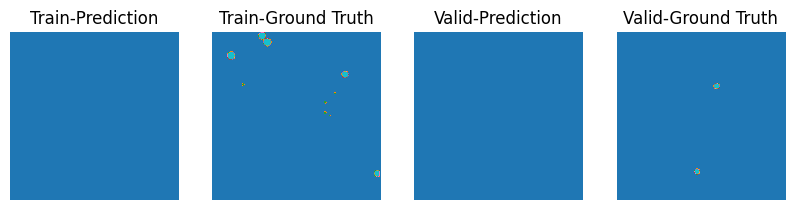

Valid-Epoch: 10, Loss: 0.10803210801880239: 100%|██████████| 368/368 [00:21<00:00, 17.19it/s]


Epoch: 10, Loss: 0.07222506403923035


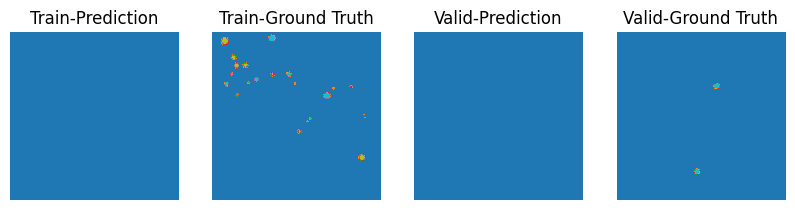

Valid-Epoch: 11, Loss: 0.1032811874402282: 100%|██████████| 368/368 [00:21<00:00, 16.92it/s] 


Epoch: 11, Loss: 0.07985635846853256


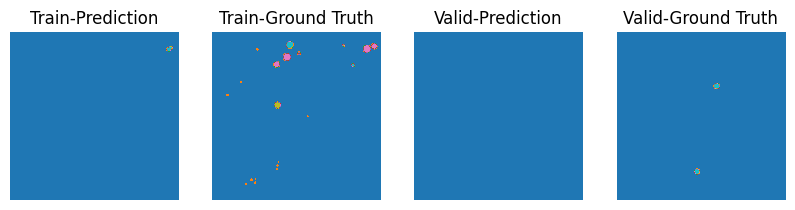

Valid-Epoch: 12, Loss: 0.10970753678323134: 100%|██████████| 368/368 [00:21<00:00, 17.01it/s]


Epoch: 12, Loss: 0.08056875318288803


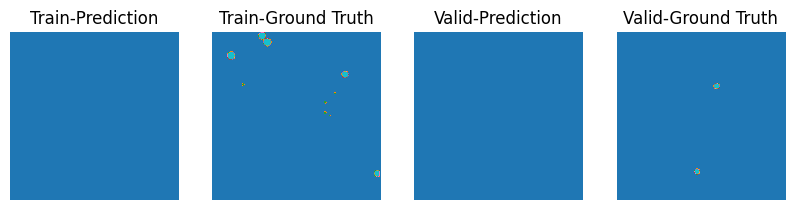

Valid-Epoch: 13, Loss: 0.1085812118532055: 100%|██████████| 368/368 [00:21<00:00, 17.02it/s] 


Epoch: 13, Loss: 0.07654522359371185


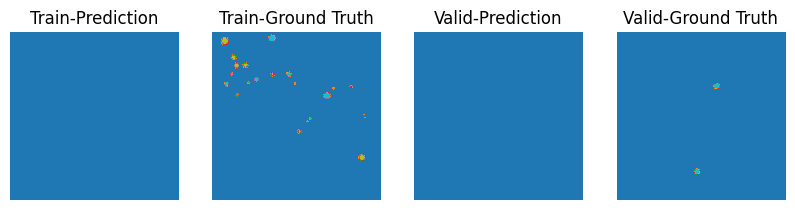

Valid-Epoch: 14, Loss: 0.10913062415024995: 100%|██████████| 368/368 [00:21<00:00, 16.84it/s]


Epoch: 14, Loss: 0.06467761099338531


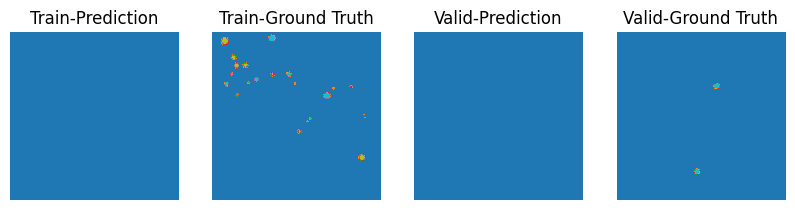

Valid-Epoch: 15, Loss: 0.10109963296892364: 100%|██████████| 368/368 [00:21<00:00, 16.88it/s] 


Epoch: 15, Loss: 0.07509679347276688


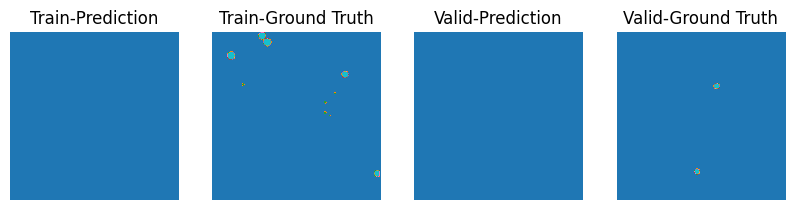

Valid-Epoch: 16, Loss: 0.10699110293416711: 100%|██████████| 368/368 [00:21<00:00, 16.81it/s]


Epoch: 16, Loss: 0.08611204475164413


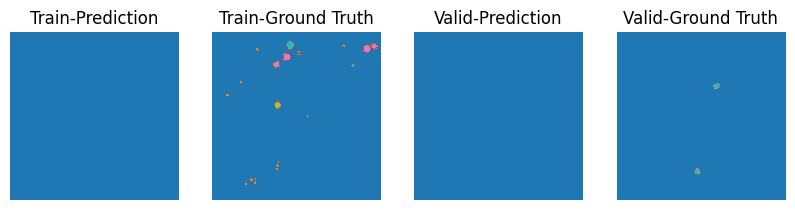

Valid-Epoch: 17, Loss: 0.10407123315836424: 100%|██████████| 368/368 [00:21<00:00, 17.04it/s] 


Epoch: 17, Loss: 0.07725637406110764


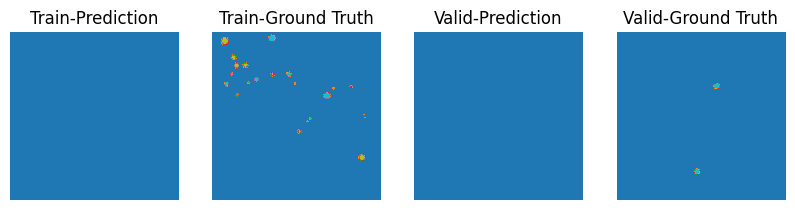

Valid-Epoch: 18, Loss: 0.10367060986944758: 100%|██████████| 368/368 [00:21<00:00, 16.86it/s] 


Epoch: 18, Loss: 0.07184389233589172


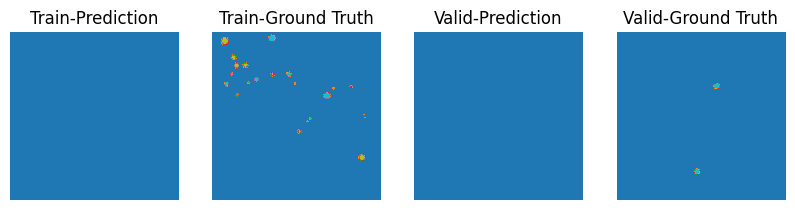

Valid-Epoch: 19, Loss: 0.10366899517121846: 100%|██████████| 368/368 [00:22<00:00, 16.70it/s]


Epoch: 19, Loss: 0.0771343931555748


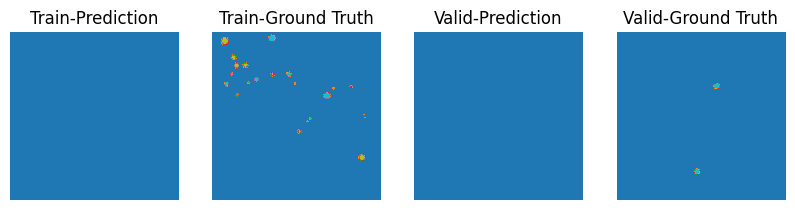

Valid-Epoch: 20, Loss: 0.10408174655268616: 100%|██████████| 368/368 [00:21<00:00, 16.83it/s] 


Epoch: 20, Loss: 0.0794394463300705


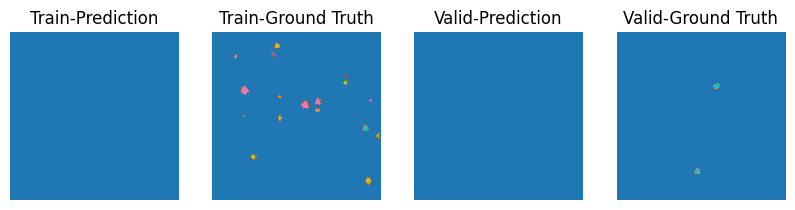

Valid-Epoch: 21, Loss: 0.10598987490495505: 100%|██████████| 368/368 [00:21<00:00, 16.94it/s] 


Epoch: 21, Loss: 0.07343728095293045


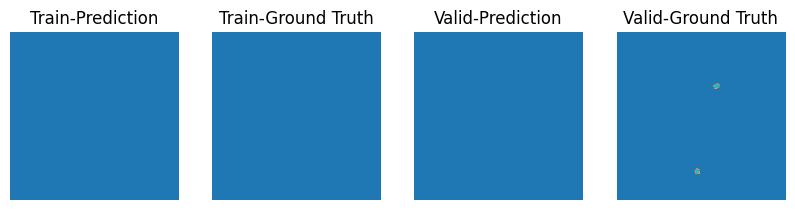

Valid-Epoch: 22, Loss: 0.10127403801079313: 100%|██████████| 368/368 [00:22<00:00, 16.70it/s] 


Epoch: 22, Loss: 0.07832043617963791


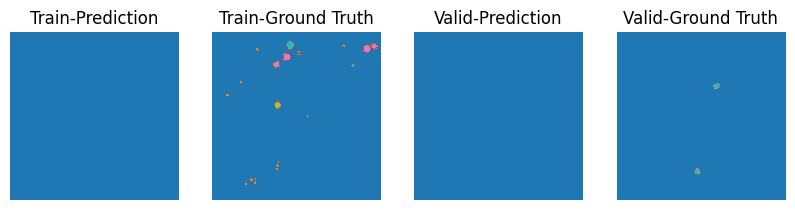

Valid-Epoch: 23, Loss: 0.1043778674616276: 100%|██████████| 368/368 [00:22<00:00, 16.62it/s] 


Epoch: 23, Loss: 0.07550685852766037


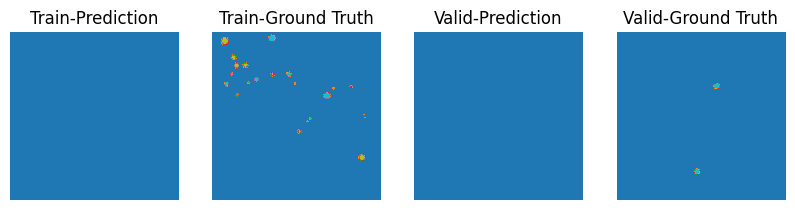

Valid-Epoch: 24, Loss: 0.1014940986870383: 100%|██████████| 368/368 [00:22<00:00, 16.72it/s]  


Epoch: 24, Loss: 0.07087911665439606


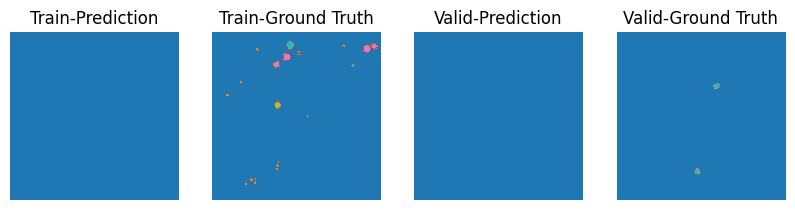

Valid-Epoch: 25, Loss: 0.10964805889702604: 100%|██████████| 368/368 [00:22<00:00, 16.72it/s] 


Epoch: 25, Loss: 0.07331866025924683


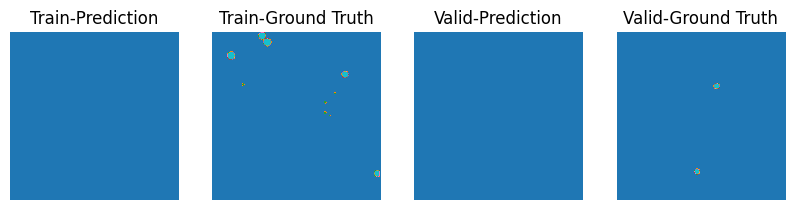

Valid-Epoch: 26, Loss: 0.10700275617621272: 100%|██████████| 368/368 [00:22<00:00, 16.58it/s] 


Epoch: 26, Loss: 0.0743032768368721


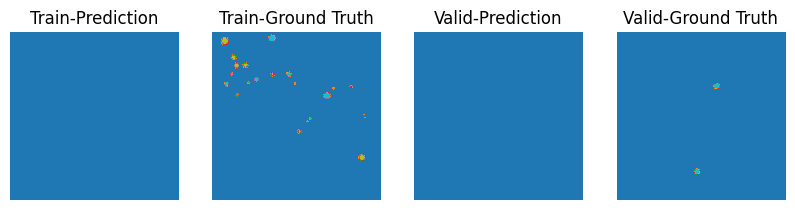

Valid-Epoch: 27, Loss: 0.11372104531746237: 100%|██████████| 368/368 [00:21<00:00, 16.83it/s] 


Epoch: 27, Loss: 0.08265727758407593


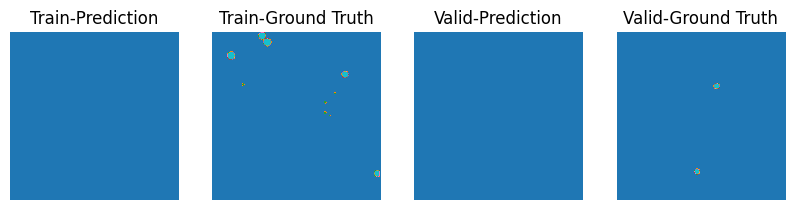

Valid-Epoch: 28, Loss: 0.1096971987572033: 100%|██████████| 368/368 [00:22<00:00, 16.69it/s]  


Epoch: 28, Loss: 0.07904636859893799


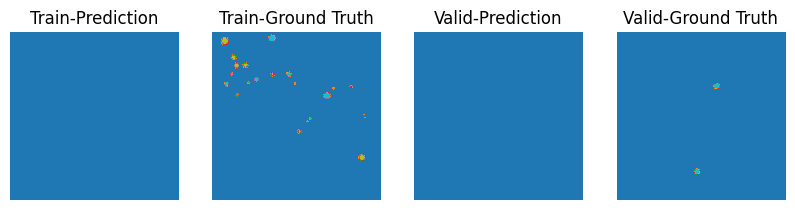

Valid-Epoch: 29, Loss: 0.11448894122883718: 100%|██████████| 368/368 [00:22<00:00, 16.68it/s] 


Epoch: 29, Loss: 0.07677768915891647


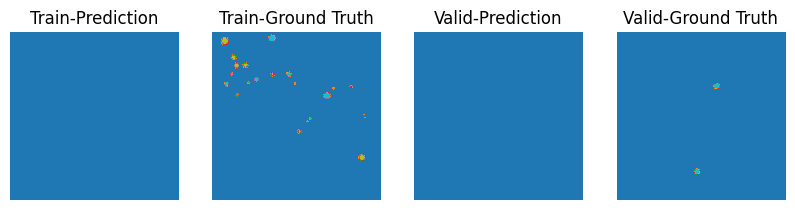

Valid-Epoch: 30, Loss: 0.11227145139634123: 100%|██████████| 368/368 [00:22<00:00, 16.68it/s]


Epoch: 30, Loss: 0.08227364718914032


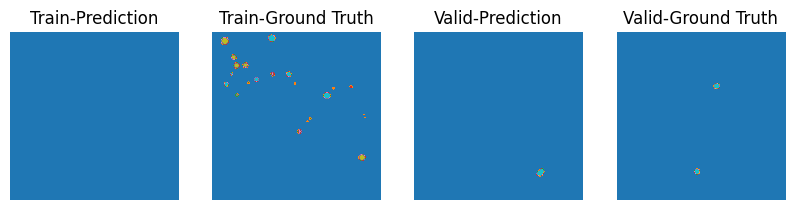

Valid-Epoch: 31, Loss: 0.11621109400268483: 100%|██████████| 368/368 [00:22<00:00, 16.67it/s]


Epoch: 31, Loss: 0.08525124192237854


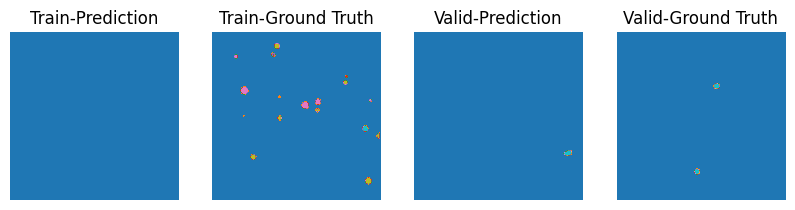

Valid-Epoch: 32, Loss: 0.1139605355261744: 100%|██████████| 368/368 [00:22<00:00, 16.72it/s] 


Epoch: 32, Loss: 0.08718269318342209


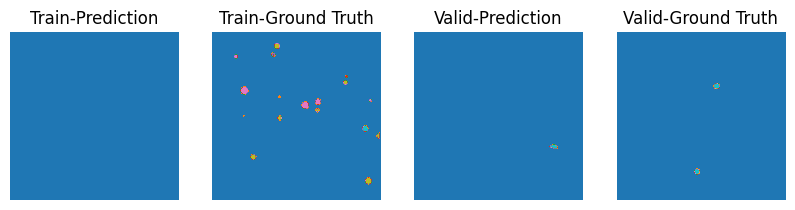

Valid-Epoch: 33, Loss: 0.18390865455907973: 100%|██████████| 368/368 [00:22<00:00, 16.57it/s]


Epoch: 33, Loss: 0.15344949066638947


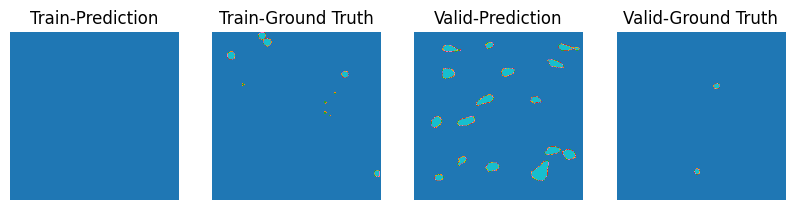

Valid-Epoch: 34, Loss: 0.12695294661629622: 100%|██████████| 368/368 [00:22<00:00, 16.67it/s]


Epoch: 34, Loss: 0.08477945625782013


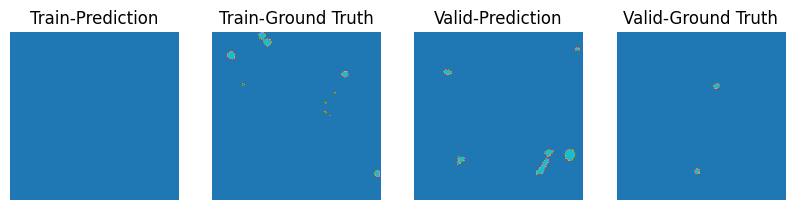

Valid-Epoch: 35, Loss: 0.12615738445184316: 100%|██████████| 368/368 [00:22<00:00, 16.53it/s] 


Epoch: 35, Loss: 0.08469035476446152


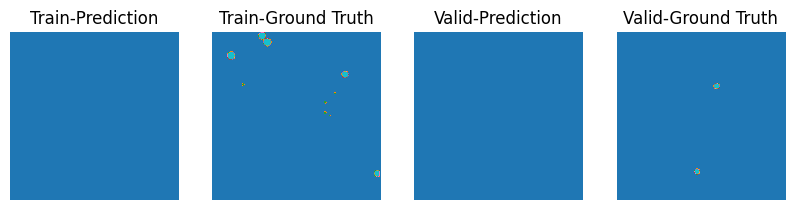

Valid-Epoch: 36, Loss: 0.1804337430563148: 100%|██████████| 368/368 [00:22<00:00, 16.59it/s] 


Epoch: 36, Loss: 0.1285705715417862


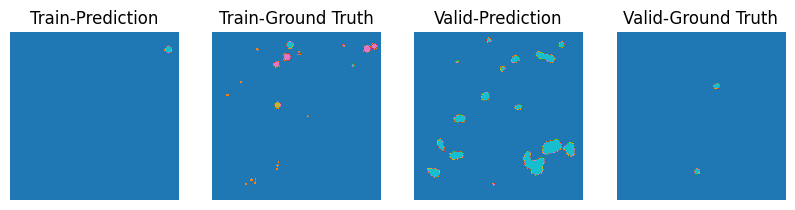

Valid-Epoch: 37, Loss: 0.15460826319885318: 100%|██████████| 368/368 [00:22<00:00, 16.60it/s]


Epoch: 37, Loss: 0.1422138661146164


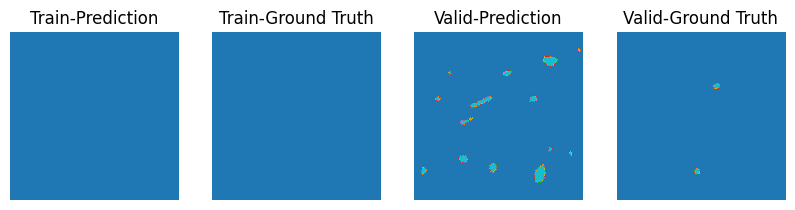

Valid-Epoch: 38, Loss: 0.19924839824924004: 100%|██████████| 368/368 [00:22<00:00, 16.69it/s]


Epoch: 38, Loss: 0.14328797161579132


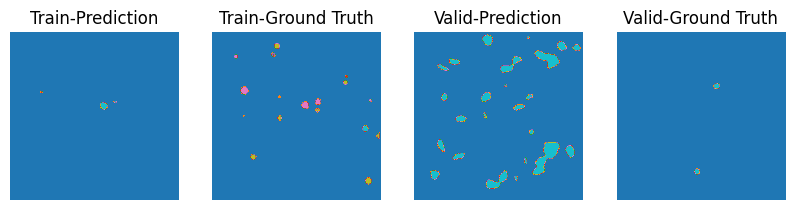

Valid-Epoch: 39, Loss: 0.1324236627399881: 100%|██████████| 368/368 [00:22<00:00, 16.70it/s]  


Epoch: 39, Loss: 0.08763647079467773


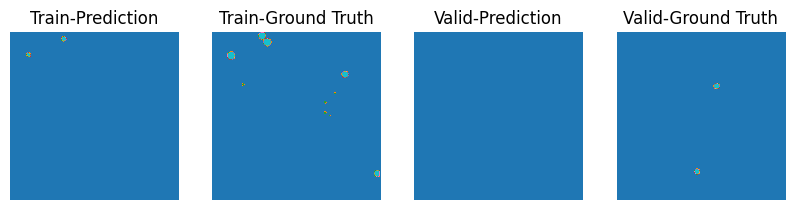

Valid-Epoch: 40, Loss: 0.2097918825507488: 100%|██████████| 368/368 [00:22<00:00, 16.67it/s] 


Epoch: 40, Loss: 0.3014354407787323


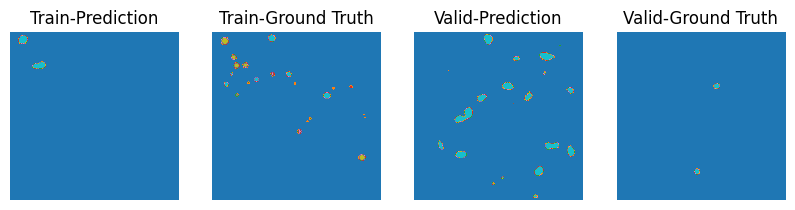

Valid-Epoch: 41, Loss: 0.13444283616516498: 100%|██████████| 368/368 [00:22<00:00, 16.71it/s]


Epoch: 41, Loss: 0.09266870468854904


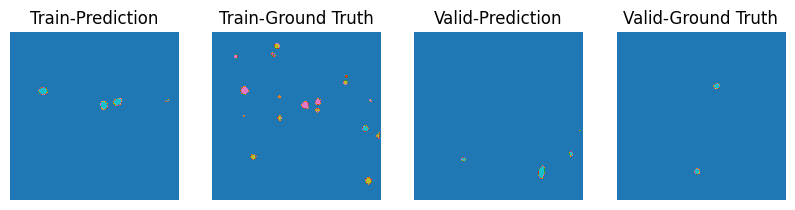

Valid-Epoch: 42, Loss: 0.14342336389286767: 100%|██████████| 368/368 [00:22<00:00, 16.61it/s] 


Epoch: 42, Loss: 0.09636259824037552


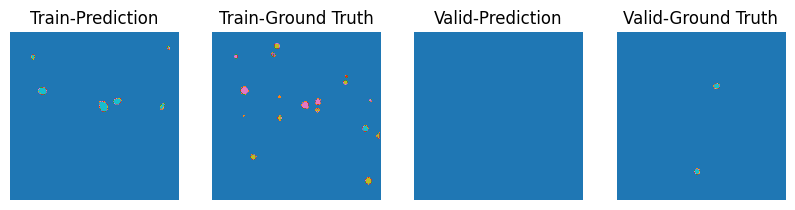

Valid-Epoch: 43, Loss: 0.2116427779926554: 100%|██████████| 368/368 [00:21<00:00, 16.74it/s] 


Epoch: 43, Loss: 0.1864149272441864


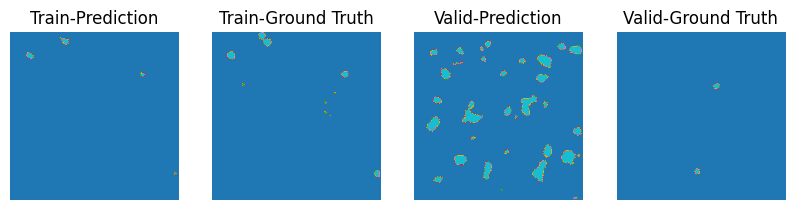

Valid-Epoch: 44, Loss: 0.1540130972204244: 100%|██████████| 368/368 [00:22<00:00, 16.54it/s]  


Epoch: 44, Loss: 0.10199199616909027


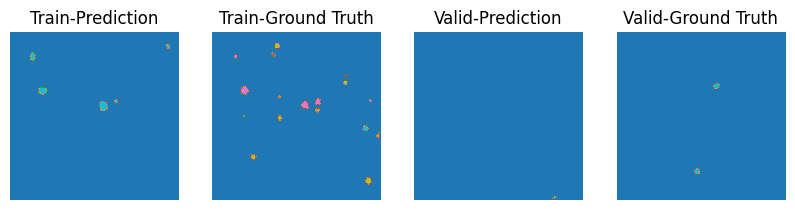

Valid-Epoch: 45, Loss: 0.1552901502123543: 100%|██████████| 368/368 [00:22<00:00, 16.57it/s]  


Epoch: 45, Loss: 0.09816905856132507


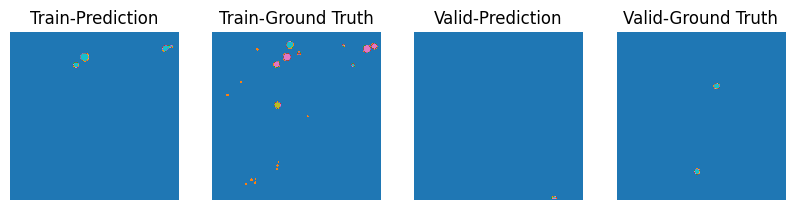

Valid-Epoch: 46, Loss: 0.15367500840638176: 100%|██████████| 368/368 [00:22<00:00, 16.70it/s] 


Epoch: 46, Loss: 0.09574250876903534


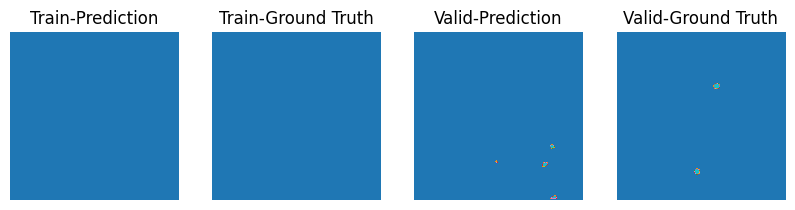

Valid-Epoch: 47, Loss: 0.2427412009615775: 100%|██████████| 368/368 [00:22<00:00, 16.61it/s] 


Epoch: 47, Loss: 0.14544780552387238


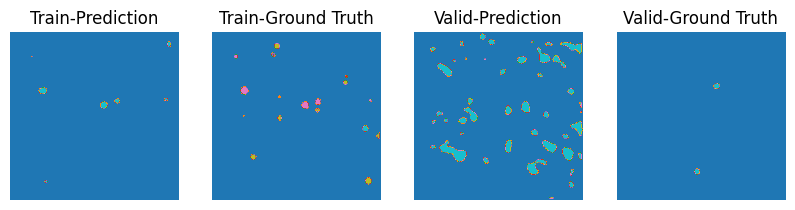

Valid-Epoch: 48, Loss: 0.20091405701216147: 100%|██████████| 368/368 [00:22<00:00, 16.72it/s]


Epoch: 48, Loss: 0.1724320352077484


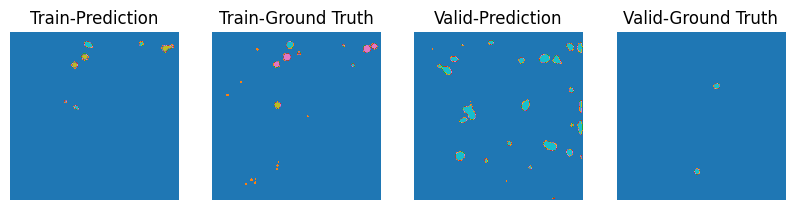

Valid-Epoch: 49, Loss: 0.1563831803733078: 100%|██████████| 368/368 [00:22<00:00, 16.59it/s]  


Epoch: 49, Loss: 0.10035651922225952


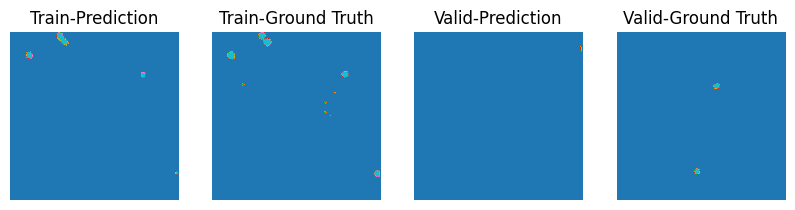

Valid-Epoch: 50, Loss: 0.16619311433295597: 100%|██████████| 368/368 [00:22<00:00, 16.72it/s]


Epoch: 50, Loss: 0.10854540020227432


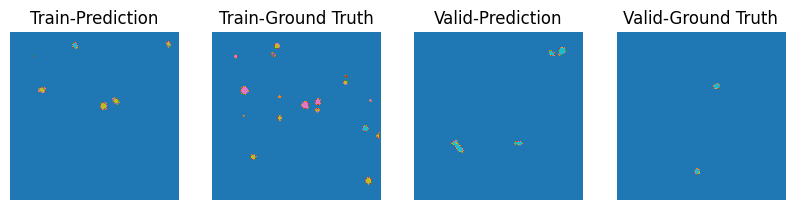

Valid-Epoch: 51, Loss: 0.1647787375828636: 100%|██████████| 368/368 [00:22<00:00, 16.57it/s] 


Epoch: 51, Loss: 0.11451545357704163


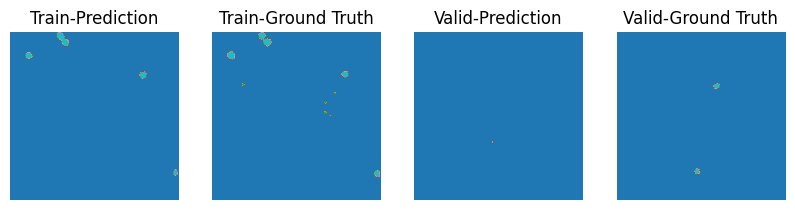

Valid-Epoch: 52, Loss: 0.1724450070548261: 100%|██████████| 368/368 [00:22<00:00, 16.66it/s]  


Epoch: 52, Loss: 0.10395882278680801


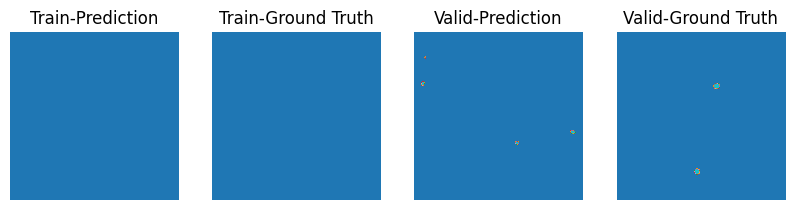

Valid-Epoch: 53, Loss: 0.1860680829233151: 100%|██████████| 368/368 [00:22<00:00, 16.68it/s] 


Epoch: 53, Loss: 0.11223400384187698


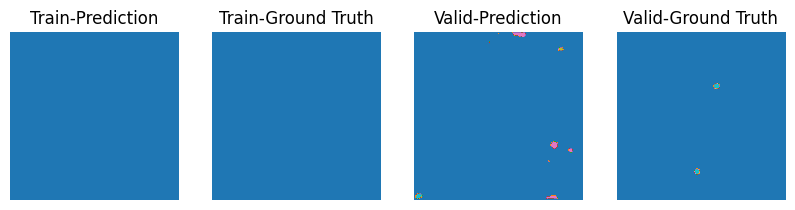

Valid-Epoch: 54, Loss: 0.16643328577502753: 100%|██████████| 368/368 [00:21<00:00, 16.73it/s]


Epoch: 54, Loss: 0.11173012107610703


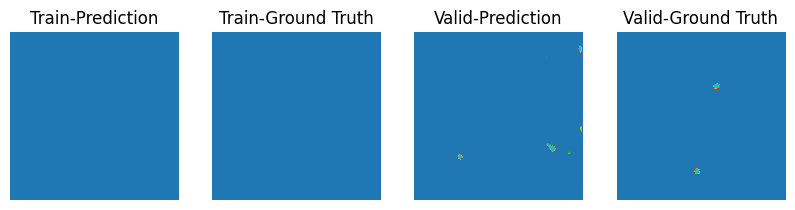

Valid-Epoch: 55, Loss: 0.1827703849235347: 100%|██████████| 368/368 [00:22<00:00, 16.63it/s] 


Epoch: 55, Loss: 0.12446294724941254


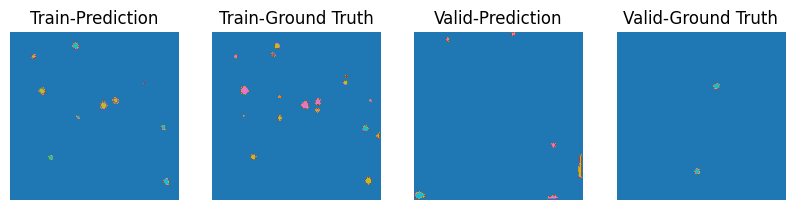

Valid-Epoch: 56, Loss: 0.23946661160975372: 100%|██████████| 368/368 [00:22<00:00, 16.56it/s]


Epoch: 56, Loss: 0.14809827506542206


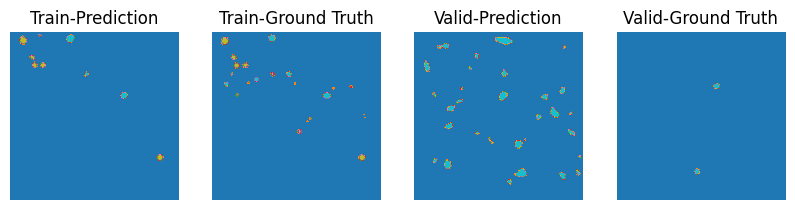

Valid-Epoch: 57, Loss: 0.19644097399103214: 100%|██████████| 368/368 [00:22<00:00, 16.57it/s]


Epoch: 57, Loss: 0.12331394106149673


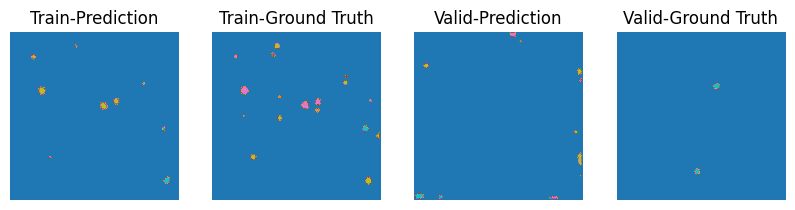

Valid-Epoch: 58, Loss: 0.1922747010413213: 100%|██████████| 368/368 [00:22<00:00, 16.59it/s]  


Epoch: 58, Loss: 0.13358673453330994


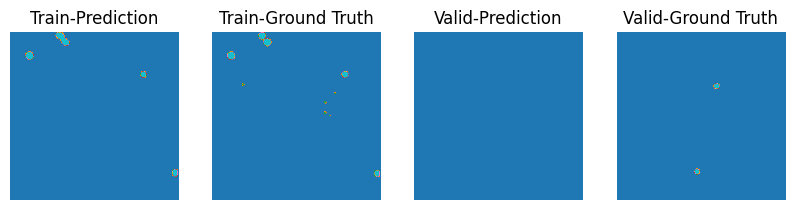

Valid-Epoch: 59, Loss: 0.20857416481569246: 100%|██████████| 368/368 [00:22<00:00, 16.61it/s]


Epoch: 59, Loss: 0.1631038337945938


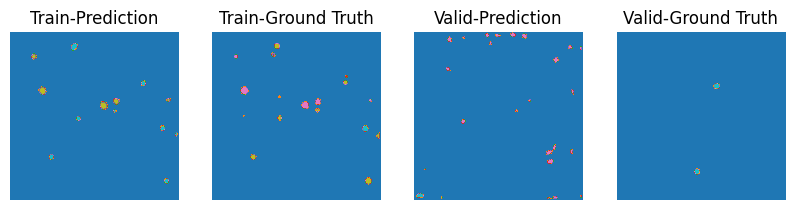

Valid-Epoch: 60, Loss: 0.23340292137278162: 100%|██████████| 368/368 [00:22<00:00, 16.69it/s]


Epoch: 60, Loss: 0.16812336444854736


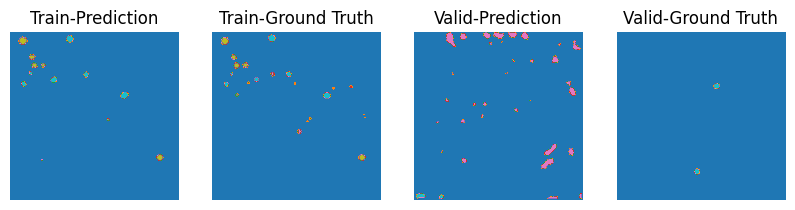

Valid-Epoch: 61, Loss: 0.21258144589513034: 100%|██████████| 368/368 [00:22<00:00, 16.71it/s] 


Epoch: 61, Loss: 0.14055176079273224


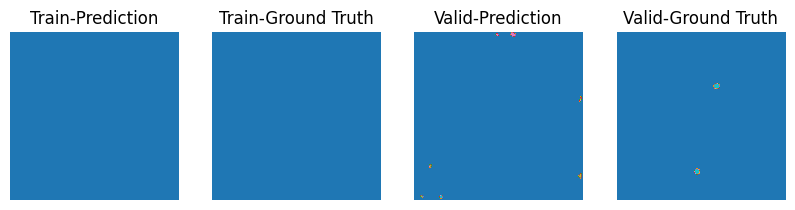

Valid-Epoch: 62, Loss: 0.20924549202217071: 100%|██████████| 368/368 [00:22<00:00, 16.72it/s]


Epoch: 62, Loss: 0.14478185772895813


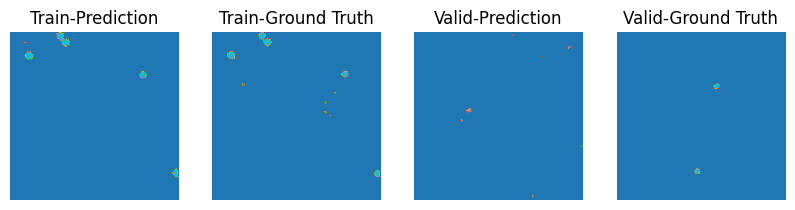

Valid-Epoch: 63, Loss: 0.21680176681294813: 100%|██████████| 368/368 [00:22<00:00, 16.60it/s] 


Epoch: 63, Loss: 0.14936761558055878


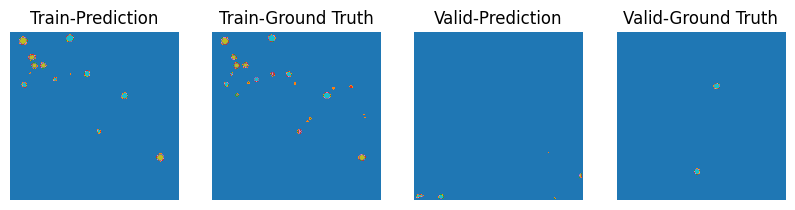

Valid-Epoch: 64, Loss: 0.21640068487360384: 100%|██████████| 368/368 [00:22<00:00, 16.42it/s]


Epoch: 64, Loss: 0.1469232738018036


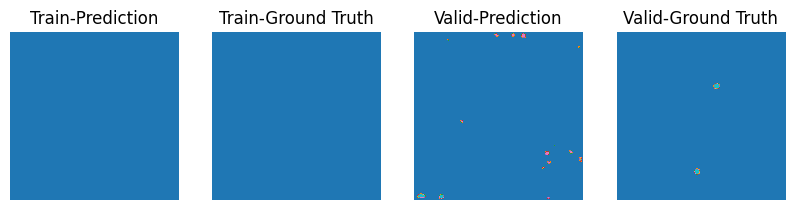

Valid-Epoch: 65, Loss: 0.22178293339485486: 100%|██████████| 368/368 [00:22<00:00, 16.56it/s] 


Epoch: 65, Loss: 0.13925562798976898


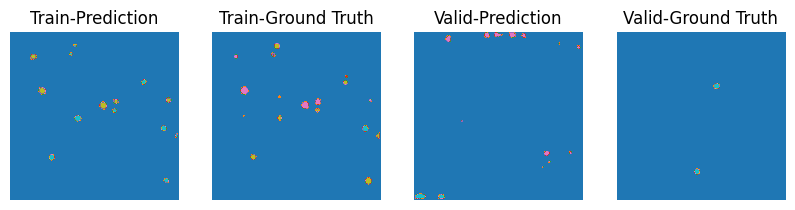

Valid-Epoch: 66, Loss: 0.22738832719472196: 100%|██████████| 368/368 [00:22<00:00, 16.54it/s] 


Epoch: 66, Loss: 0.14510823786258698


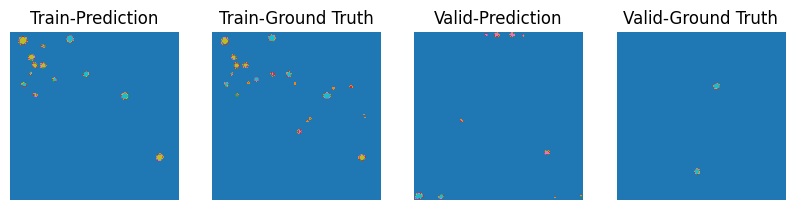

Valid-Epoch: 67, Loss: 0.23402490823671385: 100%|██████████| 368/368 [00:22<00:00, 16.58it/s]


Epoch: 67, Loss: 0.15195660293102264


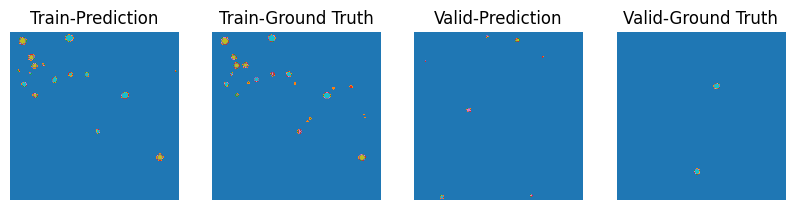

Valid-Epoch: 68, Loss: 0.25166907245725073: 100%|██████████| 368/368 [00:22<00:00, 16.58it/s] 


Epoch: 68, Loss: 0.16078083217144012


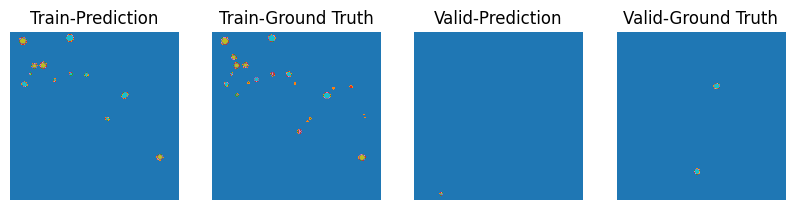

Valid-Epoch: 69, Loss: 0.24325340422080405: 100%|██████████| 368/368 [00:22<00:00, 16.56it/s] 


Epoch: 69, Loss: 0.1519477516412735


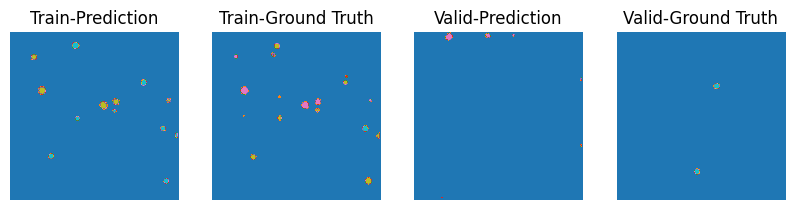

Valid-Epoch: 70, Loss: 0.2338964785085409: 100%|██████████| 368/368 [00:22<00:00, 16.57it/s]  


Epoch: 70, Loss: 0.1310296207666397


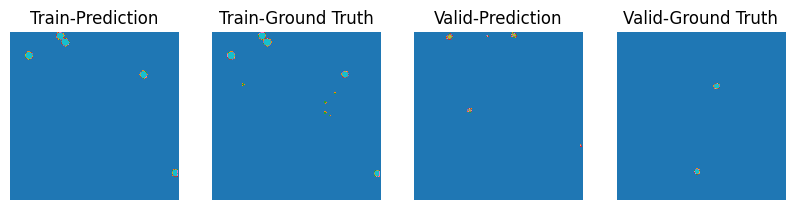

Valid-Epoch: 71, Loss: 0.22356200969332587: 100%|██████████| 368/368 [00:22<00:00, 16.62it/s]


Epoch: 71, Loss: 0.12736016511917114


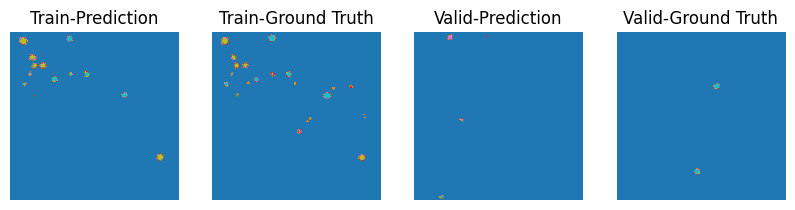

Valid-Epoch: 72, Loss: 0.2575449388899395: 100%|██████████| 368/368 [00:22<00:00, 16.68it/s] 


Epoch: 72, Loss: 0.2527921199798584


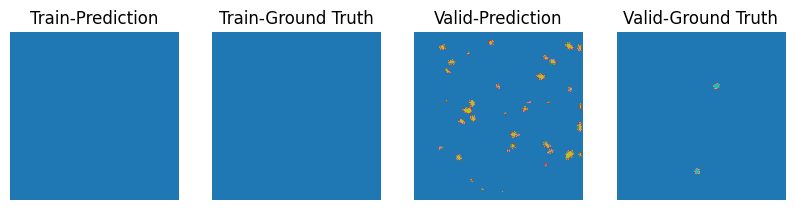

Valid-Epoch: 73, Loss: 0.24888563304810543: 100%|██████████| 368/368 [00:22<00:00, 16.13it/s] 


Epoch: 73, Loss: 0.17221879959106445


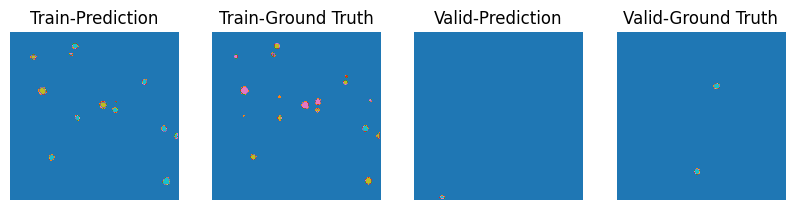

Valid-Epoch: 74, Loss: 0.2618277237071079: 100%|██████████| 368/368 [00:22<00:00, 16.54it/s]  


Epoch: 74, Loss: 0.1889040321111679


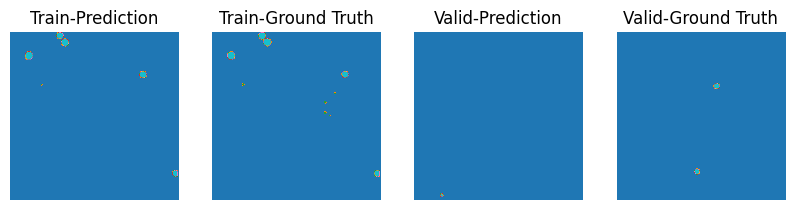

Valid-Epoch: 75, Loss: 0.2623493256700306: 100%|██████████| 368/368 [00:22<00:00, 16.26it/s]  


Epoch: 75, Loss: 0.1668836623430252


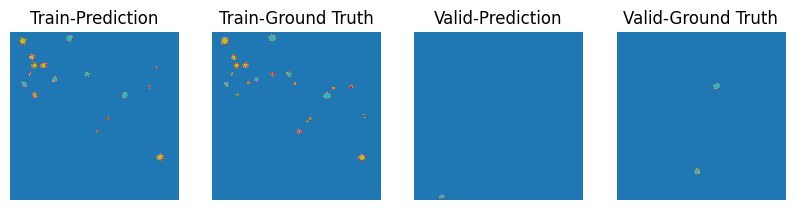

Valid-Epoch: 76, Loss: 0.23800248328378706: 100%|██████████| 368/368 [00:22<00:00, 16.47it/s] 


Epoch: 76, Loss: 0.14598700404167175


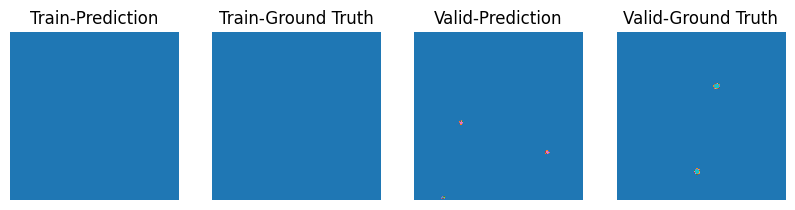

Valid-Epoch: 77, Loss: 0.25282192687059846: 100%|██████████| 368/368 [00:22<00:00, 16.27it/s] 


Epoch: 77, Loss: 0.1739732176065445


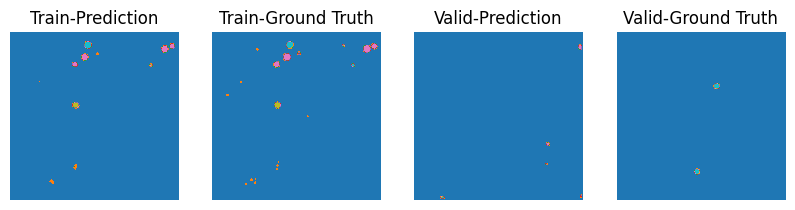

Valid-Epoch: 78, Loss: 0.26317237197050103: 100%|██████████| 368/368 [00:22<00:00, 16.30it/s] 


Epoch: 78, Loss: 0.16066911816596985


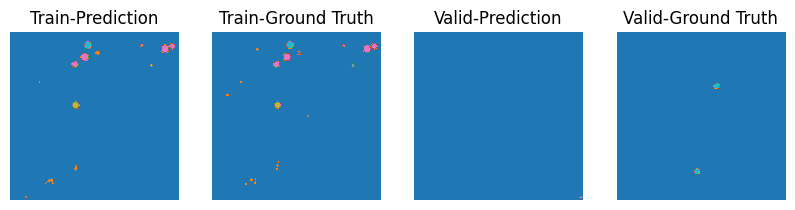

Valid-Epoch: 79, Loss: 0.26448734957470466: 100%|██████████| 368/368 [00:22<00:00, 16.40it/s] 


Epoch: 79, Loss: 0.175211563706398


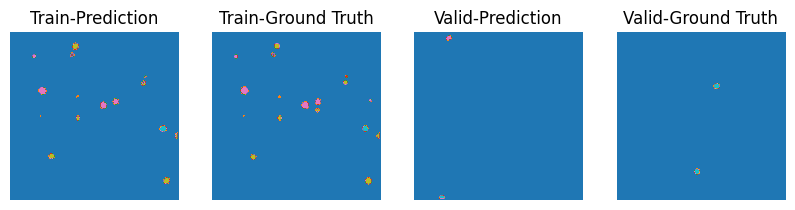

Valid-Epoch: 80, Loss: 0.25328141432271917: 100%|██████████| 368/368 [00:22<00:00, 16.28it/s]  


Epoch: 80, Loss: 0.16452743113040924


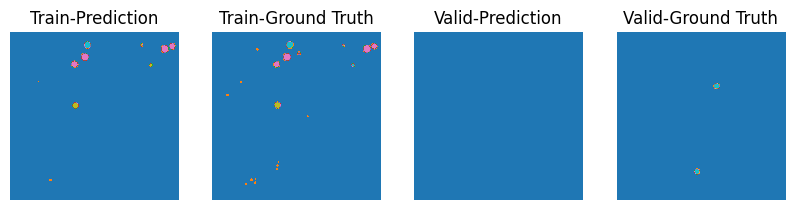

Valid-Epoch: 81, Loss: 0.25588489304367534: 100%|██████████| 368/368 [00:22<00:00, 16.48it/s] 


Epoch: 81, Loss: 0.1711076945066452


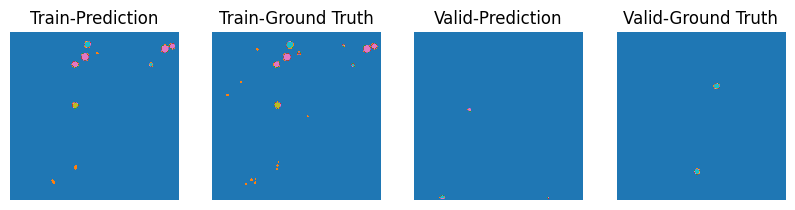

Valid-Epoch: 82, Loss: 0.2592976238298908: 100%|██████████| 368/368 [00:23<00:00, 15.81it/s] 


Epoch: 82, Loss: 0.1721087098121643


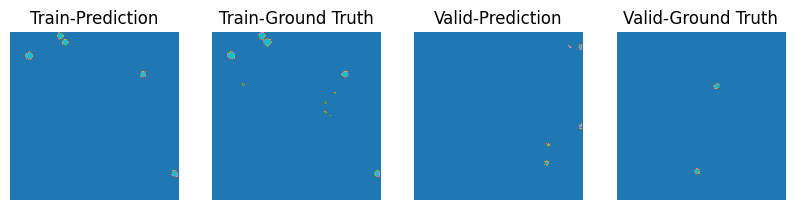

Valid-Epoch: 83, Loss: 0.2541479633528861: 100%|██████████| 368/368 [00:22<00:00, 16.54it/s]  


Epoch: 83, Loss: 0.16492778062820435


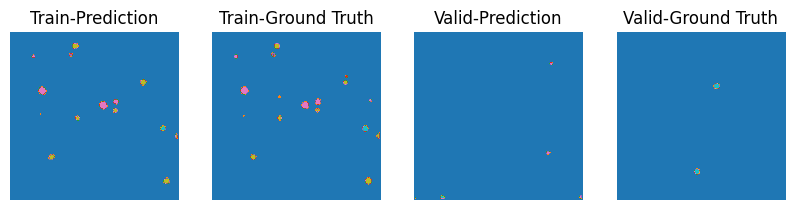

Valid-Epoch: 84, Loss: 0.2678923290654498: 100%|██████████| 368/368 [00:22<00:00, 16.14it/s]   


Epoch: 84, Loss: 0.16888053715229034


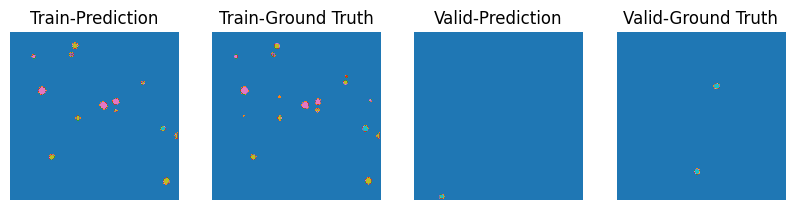

Valid-Epoch: 85, Loss: 0.26619131181146455: 100%|██████████| 368/368 [00:22<00:00, 16.30it/s] 


Epoch: 85, Loss: 0.1842307597398758


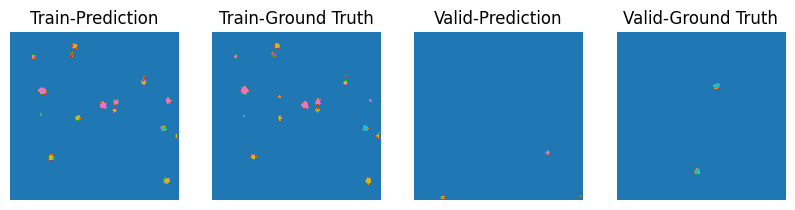

Valid-Epoch: 86, Loss: 0.2614738733794619: 100%|██████████| 368/368 [00:23<00:00, 15.65it/s]  


Epoch: 86, Loss: 0.17903710901737213


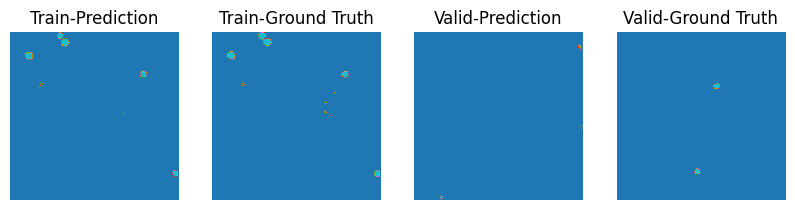

Valid-Epoch: 87, Loss: 0.270326335270748: 100%|██████████| 368/368 [00:22<00:00, 16.27it/s]   


Epoch: 87, Loss: 0.17579536139965057


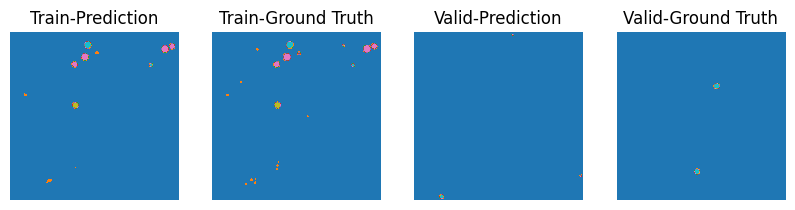

Valid-Epoch: 88, Loss: 0.2570454559912753: 100%|██████████| 368/368 [00:22<00:00, 16.47it/s]  


Epoch: 88, Loss: 0.16484390199184418


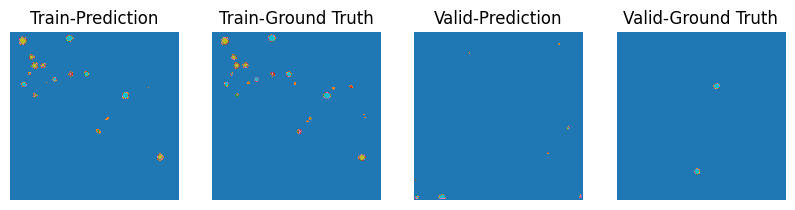

Valid-Epoch: 89, Loss: 0.2795019394043661: 100%|██████████| 368/368 [00:22<00:00, 16.49it/s]  


Epoch: 89, Loss: 0.18372172117233276


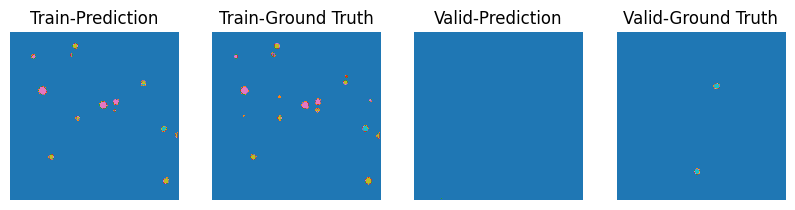

Valid-Epoch: 90, Loss: 0.26205112291704014: 100%|██████████| 368/368 [00:22<00:00, 16.45it/s] 


Epoch: 90, Loss: 0.1704920530319214


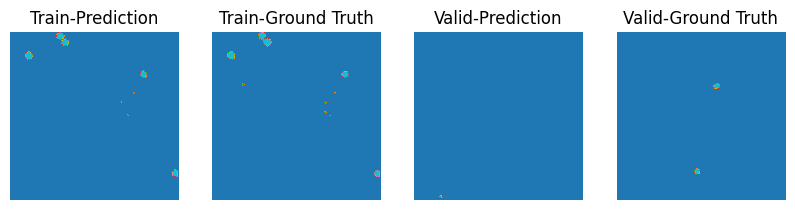

Valid-Epoch: 91, Loss: 0.2764725937150497: 100%|██████████| 368/368 [00:23<00:00, 15.93it/s]   


Epoch: 91, Loss: 0.17438587546348572


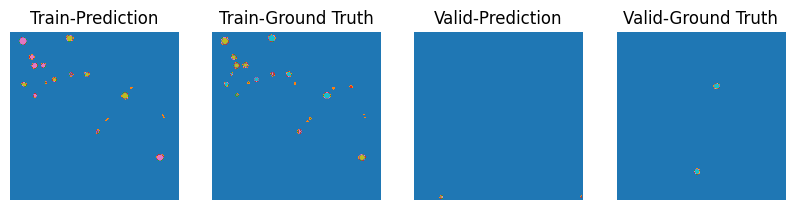

Valid-Epoch: 92, Loss: 0.25200537367440434: 100%|██████████| 368/368 [00:22<00:00, 16.35it/s]


Epoch: 92, Loss: 0.16279259324073792


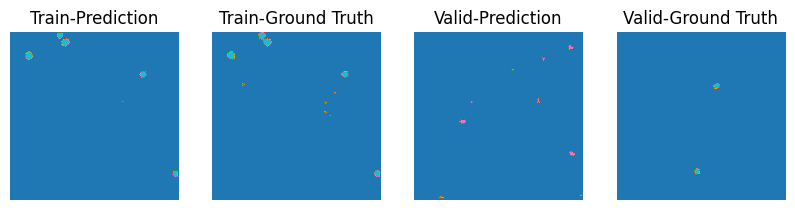

Valid-Epoch: 93, Loss: 0.27090627782387816: 100%|██████████| 368/368 [00:22<00:00, 16.26it/s] 


Epoch: 93, Loss: 0.18697117269039154


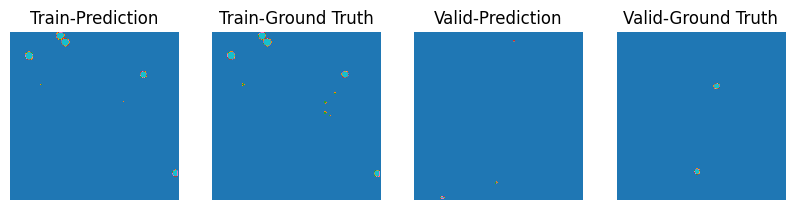

Valid-Epoch: 94, Loss: 0.26863292287769425: 100%|██████████| 368/368 [00:22<00:00, 16.30it/s] 


Epoch: 94, Loss: 0.16701315343379974


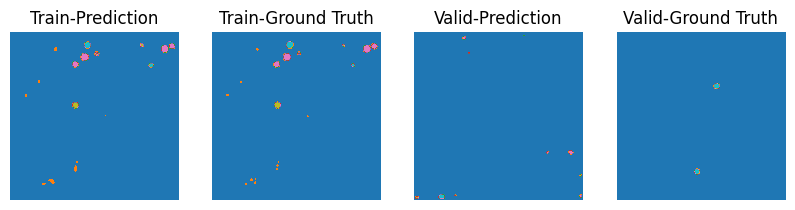

Valid-Epoch: 95, Loss: 0.2732221470040436: 100%|██████████| 368/368 [00:23<00:00, 15.92it/s]  


Epoch: 95, Loss: 0.1768246442079544


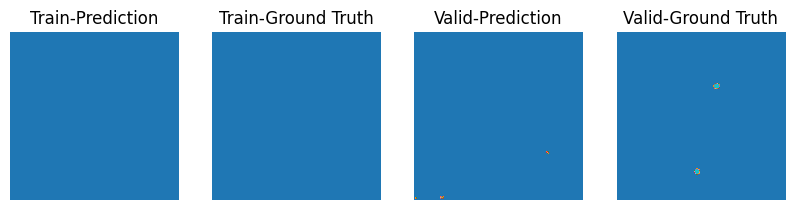

Valid-Epoch: 96, Loss: 0.2963757202321532: 100%|██████████| 368/368 [00:22<00:00, 16.07it/s]  


Epoch: 96, Loss: 0.20483194291591644


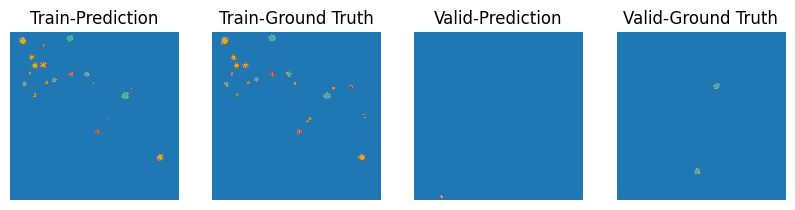

Valid-Epoch: 97, Loss: 0.2680505786354289: 100%|██████████| 368/368 [00:22<00:00, 16.33it/s] 


Epoch: 97, Loss: 0.18950578570365906


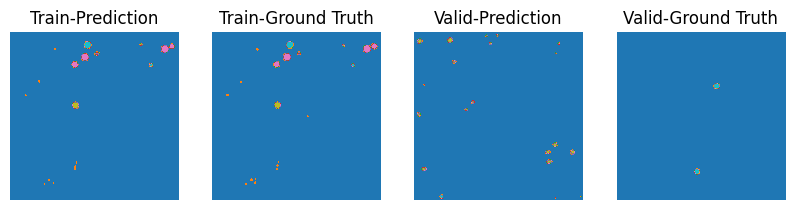

Valid-Epoch: 98, Loss: 0.2696948335487041: 100%|██████████| 368/368 [00:22<00:00, 16.21it/s] 


Epoch: 98, Loss: 0.1568479984998703


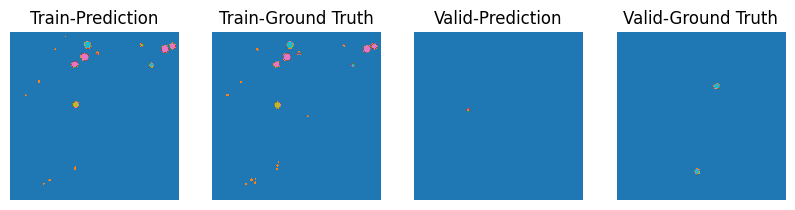

Valid-Epoch: 99, Loss: 0.2869965161181703: 100%|██████████| 368/368 [00:22<00:00, 16.29it/s]  


Epoch: 99, Loss: 0.19123102724552155


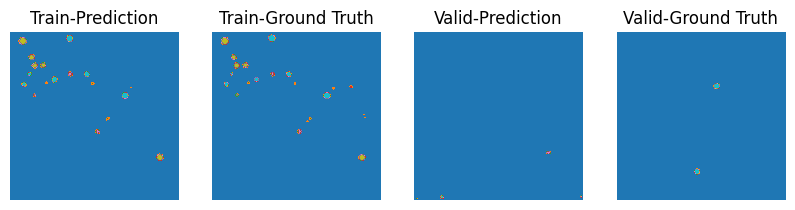

In [7]:
model = UNet_2D().to("cuda")
model.eval()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([1e-4, 1, 0, 2, 1, 2, 1]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_loss = np.inf

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = []
    train_gt_tomogram = []
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0]))
    for data in train_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            optimizer.zero_grad()
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]
            output = model(input_)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            train_pred_tomogram.append(output.cpu().detach().numpy())
            train_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    valid_pred_tomogram = []
    valid_gt_tomogram = []
    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram.append(output.cpu().detach().numpy())
            valid_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    if np.mean(valid_loss) < best_loss:
        best_loss = np.mean(valid_loss)
        best_model = model
        torch.save(best_model.state_dict(), "best_model.pth")

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # 可視化
    index = 50

    # 2つの画像を並べて表示
    # plt.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
    plt.figure(figsize=(10, 5))

    # 2つの画像を並べて表示
    ax = plt.subplot(1, 4, 1)
    ax.imshow(train_pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
    ax.set_title("Train-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(train_gt_tomogram[index].squeeze(0), cmap="tab10")
    ax.set_title("Train-Ground Truth")
    ax.axis("off")

    ax = plt.subplot(1, 4, 3)
    ax.imshow(valid_pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 4)
    ax.imshow(valid_gt_tomogram[index].squeeze(0), cmap="tab10")
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    plt.show()

In [8]:
normalized_tomogram.shape, segmentation_map.shape

((184, 640, 640), torch.Size([1, 184, 640, 640]))

In [9]:
model = UNet_2D().to("cuda")
model.load_state_dict(torch.load("best_model.pth"))
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([1e-4, 1, 0, 2, 1, 2, 1]).to("cuda")
)

pred_tomogram = []
gt_tomogram = []

valid_loss = []

model.eval()
tq = tqdm(valid_loader)
for data in valid_loader:
    tomogram = data["normalized_tomogram"].to("cuda")
    segmentation_map = data["segmentation_map"].to("cuda").long()

    for i in range(tomogram.shape[1]):
        input_ = tomogram[:, i].unsqueeze(0)
        gt = segmentation_map[:, i]

        output = model(input_)
        loss = criterion(output, gt)

        valid_loss.append(loss.item())
        tq.set_description(f"Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
        tq.update(1)

        pred_tomogram.append(output.cpu().detach().numpy())
        gt_tomogram.append(gt.cpu().detach().numpy())
tq.close()

Epoch: 99, Loss: 0.10109963296892364: : 368it [00:23, 15.66it/s]                    


In [10]:
len(pred_tomogram), len(gt_tomogram)

(368, 368)

In [11]:
pred_tomogram[0].argmax(1).shape

(1, 640, 640)

In [12]:
pred_tomogram[0].argmax(1)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

(-0.5, 639.5, 639.5, -0.5)

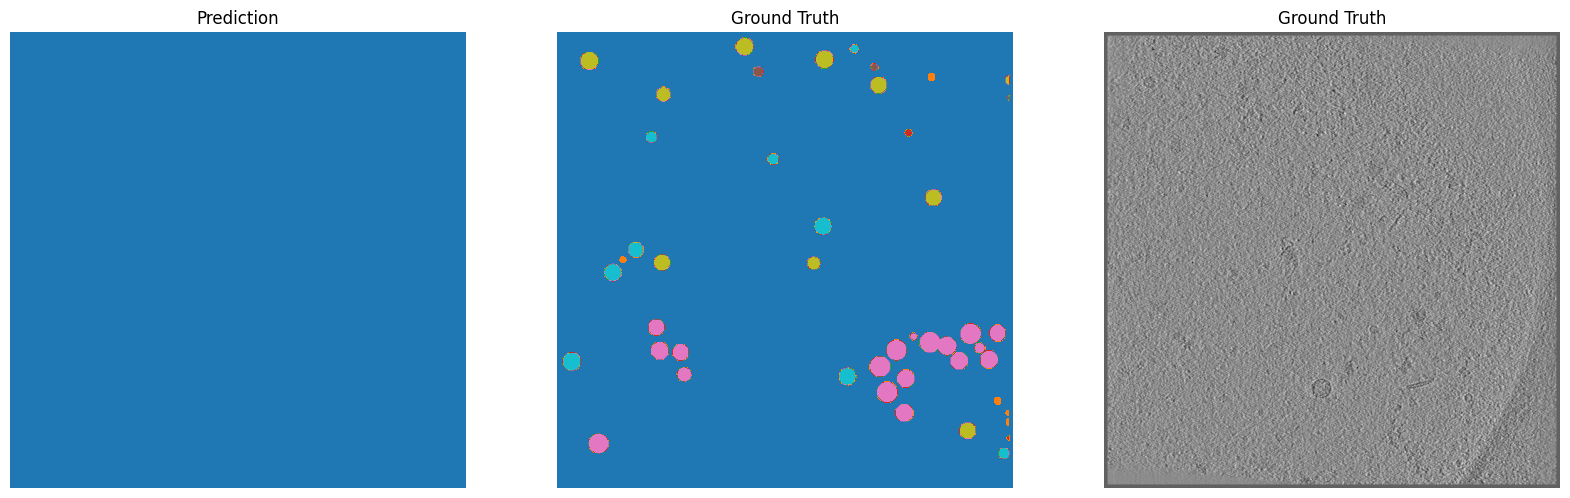

In [13]:
# 可視化
index = 120

# 2つの画像を並べて表示
# plt.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
plt.figure(figsize=(20, 10))

# 2つの画像を並べて表示
ax = plt.subplot(1, 3, 1)
ax.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
ax.set_title("Prediction")
ax.axis("off")

ax = plt.subplot(1, 3, 2)
ax.imshow(gt_tomogram[index].squeeze(0), cmap="tab10")
ax.set_title("Ground Truth")
ax.axis("off")

ax = plt.subplot(1, 3, 3)
ax.imshow(normalized_tomogram[index], cmap="gray")
ax.set_title("Ground Truth")
ax.axis("off")

In [14]:
normalized_tomogram[index]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
gt_tomogram[index].squeeze(0).shape

(640, 640)

In [16]:
pred_tomogram[index].argmax(1).shape

(1, 640, 640)